In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Flatten, Conv2D, TimeDistributed
from datetime import datetime
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

2024-09-14 17:16:16.664053: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 17:16:16.664383: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 17:16:16.666018: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 17:16:16.670948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 17:16:16.678961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

Imagemodel: Este modelo se utiliza para extraer las caracteristicas de las que contienen las etiquetas de tipos de nubes, (4 etiquetas en total).  VGG16 es un algoritmo de clasificación y detección utilizado para clasificar 1000 imagenes de 1000 diferentes categorías con un 92.7% de presición.

In [3]:
class ImageModel(tf.keras.Model):
    """
    Clase que contiene el modelo de redes convolucionales  encargada de extraer carácterísticas esenciales de las imagenes, en este caso
    el producto del ABI que contiene la probabilidad de existencia de nubosidad.
    
    Base_model = VGG16(...) Red neuronal preentrenada con 1000 iamgenes que contienen 1000 diferentes categorías.
    Args:
        1. weights = imagenet: el modelo se inicializará con los pesos aprendidos al entrenar VGG16 en el conjunto de datos de imagenet,
        una base de 1000 diferentes categorías. Util para clasificar bordes, texturas, formas.
        2. Include_top=False: Se exluye la ultima capa la cual contiene 1000 neuronas utilizadas para clasificar de acuerdo con el dataset
        de imagenes contenido en el dataset de imagenet. Solo se usa este modelo para extraer patrones e información importante.
        3. Input_shape = (300, 300, 3): Por rendimiento, logré utilizar imagenes de resolución de 300x300 con 3 canales referidos al RGB.
    
    Extracción de características:self.feature_extractor = Model(..)
    extraer la salida de la red neuronal y transformarla en un vector unidimensional.
    Args:
        1. inputs=base_model.input: entrada de la red convolucional VGG16.
        2. outputs=Flatten()(base_model.output): Salida de la red convolusional. Función flatten() para convertir en unidimencsional.
    
    Definición del flujo de datos: def call(...), se usa para llamar al modelo. En este caso cree el modelo base_model y lo llamo con el
    parámetro inputs, que serán las imagenes.
    return self.feature_extractor(inputs): la entrada son la imagenes y retorna el vector unitario con las características.
    """
    def __init__(self):
        super(ImageModel, self).__init__()
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
        self.feature_extractor = Model(inputs=base_model.input, outputs=Flatten()(base_model.output))
    
    def call(self, inputs):
        # Extraer las características de las imágenes
        return self.feature_extractor(inputs)
    
class NumericalModel(tf.keras.Model):
    """
    Esta clase contiene un modelo para entrenas datos numéricos.
        1. tf.keras.sequential(): Las capas iran conectadas de manera secuencial.
        2. tf.keras.layers.Dense(128, activation='relu'): Capa totalmente conectada con 128 neuronas con función de activación
        Relu.
        3. tf.keras.layers.Dense(64, activation='relu'): Capa totalmente conectada con 64 neuronas con función de activación
        Relu.
    Definición del flujo de datos: def call(...): al igual que el anterior, se recibe una secuencia de datos numericos y se 
    retorna la salida de la red neuronal.
    """
    def __init__(self,num_units_numeric=128, activation='relu'):
        super(NumericalModel, self).__init__()
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(num_units_numeric, activation=activation),
            tf.keras.layers.Dense(int(num_units_numeric / 2), activation=activation)
        ])

    def call(self, inputs):
        return self.fc(inputs)

class CombinedModel(tf.keras.Model):
    """
    Objetivo: Combinar las salidas de los modelos anteriores para procesarlas de manera conjunta. Muy aspero!!
        1. self.image_model = ImageModel(...): En esta linea, llamamos la clase que contiene el modelo que procesa las imagenes. Ojo, recibe
        las imagenes y retorna el vector de 1 variable.
        2. self.numerical_model = NumericalModel(): Recibe los datos numéricos y extrae las características.

    self.fc = tf.keras.Sequential(...): Capda densa, totalmente conectada de manera secuencial por donde se pasarán lo datos combinados.
        1. tf.keras.layers.Dense(256, activation='relu'): Capa densa totalmente conectada de 256 neuronas con función de activacióN Relu.
        2. tf.keras.layers.Dense(1). Capa de salida, 1 porque es un vector numérico.

    Definición de flujo de datos:
        Se reciben los dastos numéricos y las imagenes. 
        1. image_features = self.image_model(image_inputs): Pasamos la lista de imagenes a traves del modelo VGG16.
        2. numerical_features = self.numerical_model(numerical_inputs): Pasamos la lista de números a traves del modelo numérico.
        3. combined = tf.concat([image_features, numerical_features], axis=1): Combinamos las salidas de los modelos y hacemos haga de cuenta un
        vector gigante.
        4. self.fc(combined): La entrada de la capa densa son el vector de una dimensión con todos los datos y la salida es el valor de regresión,
        utilizo (1) para predecir un valor numérico.
    """
    def __init__(self, num_units_image=256, num_units_numeric=128, activation='relu'):
        super(CombinedModel, self).__init__()
        self.image_model = ImageModel()  # Modelo de imágenes
        self.numerical_model = NumericalModel(num_units_numeric=num_units_numeric, activation=activation)  # Modelo numérico
        
        # Capa combinada final
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(num_units_image, activation=activation),
            tf.keras.layers.Dense(1)  # Salida final
        ])
    
    def call(self, inputs):
        image_inputs, numerical_inputs = inputs  
        image_features = self.image_model(image_inputs)
        numerical_features = self.numerical_model(numerical_inputs)
        combined = tf.concat([image_features, numerical_features], axis=1)
        return self.fc(combined)

In [4]:
# adecuar modelo para gridsearchCV

def build_combined_model(optimizer='adam', activation='relu', num_units_image=256, num_units_numeric=128):
    model = CombinedModel(num_units_image=num_units_image, num_units_numeric=num_units_numeric, activation=activation)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [5]:
carpeta_resultado = 'C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/metricas_modelo'

if not os.path.exists(carpeta_resultado):
    os.makedirs(carpeta_resultado)
    print(f'Carpeta creada: {carpeta_resultado}')
else:
    print(f'La carpeta ya existe: {carpeta_resultado}')



La carpeta ya existe: C:/Users/guavitaj/Documents/tesis/algoritmos/modelo_xray/metricas_modelo


In [6]:
def plot_loss(history, fold):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
    plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
    plt.title(f'Pérdida por Época (Fold {fold})')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (Loss)')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(f'{carpeta_resultado}/plot_loss_{fold}.png')
    plt.close()



In [7]:

import os
import matplotlib.pyplot as plt

def plot_predictions_vs_actual(y_test, y_test_pred, fold, best_fold=None, carpeta_resultado='./resultados'):
    
    y_test_flat = y_test.flatten()
    y_pred_flat = y_test_pred.flatten()

    if not os.path.exists(carpeta_resultado):
        os.makedirs(carpeta_resultado)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(y_test_flat, label='Valores reales (Test)', color='blue', marker='o')
    plt.plot(y_pred_flat, label='Predicciones', color='red', marker='x')

    plt.title(f'Predicciones vs Valores Reales - Fold {fold}')
    plt.xlabel('Índice')
    plt.ylabel('GHI')

    if best_fold is not None and fold == best_fold:
        plt.title(f'** Mejor Fold {fold} **', fontsize=14, fontweight='bold', color='green')

    plt.legend()
    plt.grid(True)

    plt.savefig(f'{carpeta_resultado}/predicciones_vs_reales_fold_{fold}.png')

    plt.show()

    plt.close()




In [8]:
def save_best_params(mejores_porfold, best_global_params):
    df = pd.DataFrame(mejores_porfold)
    
    # Añadir los mejores hiperparámetros globales
    best_global_params['fold'] = 'global'
    df = df.append(best_global_params, ignore_index=True)
    
    df.to_csv('mejores_hiperparametros.csv', index=False)
    print("Guardado de los mejores hiperparámetros en 'mejores_hiperparametros.csv'")


In [9]:
def n_cross_val(X_images, X_numerical, y, param_grid, outer_splits=5, inner_splits=3, epochs=15, batch_size=32):
    """
    Implementación de Nested Cross Validation para optimización de hiperparámetros.
    
    Args:
    - X_images: Imágenes de entrada
    - X_numerical: Datos numéricos de entrada
    - y: Valores objetivo (GHI)
    - param_grid: Espacio de hiperparámetros para optimización
    - outer_splits: Número de folds para la validación externa (outer loop)
    - inner_splits: Número de folds para la validación interna (inner loop)
    - epochs: Número de épocas por pliegue
    - batch_size: Tamaño de lote para entrenamiento
    """

    cv_externa =  TimeSeriesSplit(n_splits=outer_splits)
    mejores_porfold = []
    outer_scores = []

    fold = 1
    modelo_mejor_global = None
    mejor_mse = np.inf
    best_fold = None 


    for train_index, test_index in cv_externa.split(X_numerical):
        X_train_images, X_test_images = X_images[train_index], X_images[test_index]
        X_train_numerical, X_test_numerical = X_numerical[train_index], X_numerical[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print(f"\n=== Fold {fold} ===")
        print(f"Forma de X_train_images: {X_train_images.shape}")
        print(f"Forma de X_train_numerical: {X_train_numerical.shape}")
        print(f"Forma de y_train: {y_train.shape}")

        # Hiperparámetros a optimizar
        best_params = None
        best_mse = np.inf

        # Validación cruzada interna para optimización de hiperparámetros
        cv_interna = TimeSeriesSplit(n_splits=inner_splits)

        for optimizer in param_grid['optimizer']:
            for activation in param_grid['activation']:
                for num_units_image in param_grid['num_units_image']:
                    for num_units_numeric in param_grid['num_units_numeric']:

                        # Evaluación interna de los hiperparámetros
                        internal_mse = []
                        for train_inner_idx, val_inner_idx in cv_interna.split(X_train_numerical):
                            X_train_inner_images, X_val_inner_images = X_train_images[train_inner_idx], X_train_images[val_inner_idx]
                            X_train_inner_numerical, X_val_inner_numerical = X_train_numerical[train_inner_idx], X_train_numerical[val_inner_idx]
                            y_train_inner, y_val_inner = y_train[train_inner_idx], y_train[val_inner_idx]

                            # Construir el modelo con los hiperparámetros actuales
                            model = build_combined_model(optimizer=optimizer, activation=activation,
                                                         num_units_image=num_units_image, num_units_numeric=num_units_numeric)

                            # Entrenar el modelo en el conjunto interno de entrenamiento
                            model.fit([X_train_inner_images, X_train_inner_numerical], y_train_inner, 
                                      epochs=epochs, batch_size=batch_size, verbose=0)

                            # Evaluar en el conjunto interno de validación
                            y_val_pred = model.predict([X_val_inner_images, X_val_inner_numerical])
                            mse_val = mean_squared_error(y_val_inner, y_val_pred)
                            internal_mse.append(mse_val)

                        # Promedio de MSE interno
                        avg_mse_val = np.mean(internal_mse)
                        print(f"Eval: Optimizer={optimizer}, Activation={activation}, Units_image={num_units_image}, Units_numeric={num_units_numeric}, MSE={avg_mse_val}")

                        # Seleccionar el mejor conjunto de hiperparámetros
                        if avg_mse_val < best_mse:
                            best_mse = avg_mse_val
                            best_params = {
                                'optimizer': optimizer,
                                'activation': activation,
                                'num_units_image': num_units_image,
                                'num_units_numeric': num_units_numeric
                            }

        # Entrenar el modelo final con los mejores hiperparámetros
        print(f"\nBest Params for Fold {fold}: {best_params}")
        mejores_porfold.append({
            'fold': fold,
            'optimizer': best_params['optimizer'],
            'activation': best_params['activation'],
            'num_units_image': best_params['num_units_image'],
            'num_units_numeric': best_params['num_units_numeric']
        })

        model_final = build_combined_model(optimizer=best_params['optimizer'], 
                                           activation=best_params['activation'], 
                                           num_units_image=best_params['num_units_image'], 
                                           num_units_numeric=best_params['num_units_numeric'])

        # Entrenar en el conjunto de entrenamiento externo completo
        history = model_final.fit([X_train_images, X_train_numerical], y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Evaluar en el conjunto de prueba externo
        y_test_pred = model_final.predict([X_test_images, X_test_numerical])
        mse_test = mean_squared_error(y_test, y_test_pred)
        outer_scores.append(mse_test)

        model_final.save(f"best_model_fold_{fold}.h5")
        print(f"Guardado el modelo del Fold {fold} en 'best_model_fold_{fold}.h5'")
        

        if mse_test < mejor_mse:
            mejor_mse = mse_test
            modelo_mejor_global = model_final
            best_global_params = best_params
            best_fold = fold 
            modelo_mejor_global.save(f"modelo_mejor_global.h5")
            print(f"Guardado el mejor modelo global en 'best_global_model.h5' con MSE: {mejor_mse}")
    

        #plot_loss(history, fold)
        plot_predictions_vs_actual(y_test, y_test_pred, fold, best_fold,carpeta_resultado)
        print(f"Fold {fold} - Test MSE: {mse_test}\n")
        fold += 1

    print(f"Outer Scores: {outer_scores}")
    print(f"Mejores hiperparámetros por fold: {mejores_porfold}")

    save_best_params(mejores_porfold, best_global_params)
    
    return outer_scores, mejores_porfold

In [10]:
def plot_mse_per_fold(mse_folds):
    # Crear el gráfico de barras para los MSE por fold
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(1, len(mse_folds) + 1), mse_folds, color='skyblue')
    plt.title('MSE por Fold')
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.xticks(range(1, len(mse_folds) + 1))
    plt.grid(True)

    # Agregar etiquetas de MSE en cada barra
    for bar, mse in zip(bars, mse_folds):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(mse, 4), ha='center', va='bottom')
    
    plt.savefig(f'{carpeta_resultado}/plot_mse_per_fold.png')
    plt.close()


In [11]:
# Resolución y 3 por RGB
height, width, channels = 64, 64, 3 

In [12]:
# Obtener el número total de imágenes
direccion = '/home/aia-workstation/Documents/modelo_xray/Images'
carpeta_imagenes = 'ACMF' 
carpeta_destino = '/home/aia-workstation/Documents/modelo_xray/filtered_images'
carpeta_resultados = 'carpeta_resultados'

image_folder = os.path.join(direccion,carpeta_imagenes)
image_files = sorted([os.path.join(image_folder,i) for i in os.listdir(image_folder) if i.endswith('.png')])


print(f"Número total de archivos de imagen: {len(image_files)}")

Número total de archivos de imagen: 864


In [13]:
imagenes_filtradas = []

if not os.path.exists(carpeta_destino):
    os.makedirs(carpeta_destino)
    print(f'Carpeta creada: {carpeta_destino}')
else:
    print(f'La carpeta ya existe: {carpeta_destino}')

# solo procesare imagenes entre las 5:00 a.m. y las 18:30, la idea es obtener una señal periódica.
for nombre_imagen in os.listdir(image_folder):
    if nombre_imagen.startswith('OR_ABI-L2-ACMF-M6_G16_'):
        fecha_hora_str = nombre_imagen.split('_')[3][1:13] 
        fecha_hora = datetime.strptime(fecha_hora_str, '%Y%m%d%H%M')
        hora = fecha_hora.time()
        hora_inicio = datetime.strptime('05:00', '%H:%M').time()
        hora_fin = datetime.strptime('18:30', '%H:%M').time()
        if hora >= hora_inicio and hora <= hora_fin:
            ruta_completa = os.path.join(image_folder, nombre_imagen)
            ruta_destino = os.path.join(carpeta_destino, nombre_imagen)
            # Copiar la imagen a la carpeta de destino
            os.system(f'copy "{ruta_completa}" "{ruta_destino}"')
            imagenes_filtradas.append((ruta_destino,fecha_hora))



La carpeta ya existe: /home/aia-workstation/Documents/modelo_xray/filtered_images


sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy: not found
sh: 1: copy

In [14]:
print(imagenes_filtradas)

[('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230703163021.png', datetime.datetime(2023, 7, 3, 16, 30)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230701175021.png', datetime.datetime(2023, 7, 1, 17, 50)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230706101022.png', datetime.datetime(2023, 7, 6, 10, 10)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230703143021.png', datetime.datetime(2023, 7, 3, 14, 30)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230706175021.png', datetime.datetime(2023, 7, 6, 17, 50)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230704103021.png', datetime.datetime(2023, 7, 4, 10, 30)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230701125021.png', datetime.datetime

In [15]:
print(imagenes_filtradas)

[('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230703163021.png', datetime.datetime(2023, 7, 3, 16, 30)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230701175021.png', datetime.datetime(2023, 7, 1, 17, 50)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230706101022.png', datetime.datetime(2023, 7, 6, 10, 10)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230703143021.png', datetime.datetime(2023, 7, 3, 14, 30)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230706175021.png', datetime.datetime(2023, 7, 6, 17, 50)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230704103021.png', datetime.datetime(2023, 7, 4, 10, 30)), ('/home/aia-workstation/Documents/modelo_xray/filtered_images/OR_ABI-L2-ACMF-M6_G16_s20230701125021.png', datetime.datetime

In [16]:
#Función para normalizar las imagenes. Las trato como una matriz tipo flotante y divido por 255 por RGB.
def load_and_preprocess_image(image_path, target_size=(height, width)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalizacion RGB
    return image

In [17]:
"""
Ojo: Ejecuto este ciclo para normalizar cada imagen filtrada en el horario seleccionado y las guardo en una lista tipo
numpy para poder utilizarlo en el modelo.
"""
image_tensors  = []

for ruta_destino, fecha_hora in imagenes_filtradas:
    image_tensor = load_and_preprocess_image(ruta_destino, target_size=(64,64))
    image_tensors.append(image_tensor)

tensor_images = np.array(image_tensors)
print(f"Formato de tensor_images: {tensor_images.shape}")


Formato de tensor_images: (492, 64, 64, 3)


In [18]:
"""
Procesamiento de datos numércos:
Utilizaré el las variables GHI como mi vairable a la salida y DoY Sin'&'DoY Cos' para intentar predecir la irradiancia, puedo tener 
la misma irradiancia en la mañana y en la tarde.
"""

df = pd.read_csv('DatosParaCompartir.csv')
df['t'] = pd.to_datetime(df['t'], utc=True)
df.set_index('t', inplace=True)
inicio = '2023-07-01'
fin = '2023-07-07'
df = df[(df.index >=inicio) & (df.index<=fin)]
df = df[(df.index.time >= pd.to_datetime('05:00:00').time()) & (df.index.time <= pd.to_datetime('18:30:00').time())]
df.reset_index(inplace=True)
scaler = MinMaxScaler()
df['GHI'] = scaler.fit_transform(df[['GHI']])
fechas = df['t'].tolist()
columnas = ['t','GHI','DoY Sin','DoY Cos']
df['t'] = pd.to_datetime(df['t']).dt.tz_localize(None)
df = df[columnas]
df.head()

,t,GHI,DoY Sin,DoY Cos
0,2023-07-01 05:00:00,0.000000,0.017166,-0.999853
1,2023-07-01 05:10:00,0.000033,0.017166,-0.999853
2,2023-07-01 05:20:00,0.000230,0.017166,-0.999853
3,2023-07-01 05:30:00,0.001937,0.017166,-0.999853
4,2023-07-01 05:40:00,0.007403,0.017166,-0.999853


In [19]:
# Creo las variables numericas y mi variable de salida para el modelo.
numericas = ['GHI','DoY Sin','DoY Cos']
valores_numericos = df[numericas].values
salida = ['GHI']
y = df[salida].values



In [20]:
print(type(valores_numericos))  
print(valores_numericos.shape)  
print(valores_numericos[:5])

<class 'numpy.ndarray'>
(492, 3)
[[ 0.00000000e+00  1.71663298e-02 -9.99852648e-01]
 [ 3.34508392e-05  1.71663298e-02 -9.99852648e-01]
 [ 2.30177937e-04  1.71663298e-02 -9.99852648e-01]
 [ 1.93653237e-03  1.71663298e-02 -9.99852648e-01]
 [ 7.40348438e-03  1.71663298e-02 -9.99852648e-01]]


In [21]:
print(type(y))  
print(y.shape)  
print(y[:5])

<class 'numpy.ndarray'>
(492, 1)
[[0.00000000e+00]
 [3.34508392e-05]
 [2.30177937e-04]
 [1.93653237e-03]
 [7.40348438e-03]]


In [22]:
# Verificar el número de muestras en imágenes, datos numéricos y etiquetas
print(f"Tamaño de tensor_images: {tensor_images.shape}")  # (492, 300, 300, 3)
print(f"Tamaño de valores_numericos: {valores_numericos.shape}")  # (492, 3)
print(f"Tamaño de y: {y.shape}")  # (492, 1)

# Asegúrate de que todos tienen el mismo número de muestras (492)
if tensor_images.shape[0] == valores_numericos.shape[0] == y.shape[0]:
    print("El número de muestras coincide en todas las entradas.")
else:
    print("El número de muestras no coincide.")


Tamaño de tensor_images: (492, 64, 64, 3)
Tamaño de valores_numericos: (492, 3)
Tamaño de y: (492, 1)
El número de muestras coincide en todas las entradas.



=== Fold 1 ===
Forma de X_train_images: (82, 64, 64, 3)
Forma de X_train_numerical: (82, 3)
Forma de y_train: (82, 1)


I0000 00:00:1726352179.709648  242580 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-14 17:16:19.710318: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=64, MSE=0.21458924569466906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=128, MSE=0.35925446380936216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=64, MSE=0.09065764294297511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=128, MSE=0.21518464152185016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Eval: Optimizer=adam, Acti

Guardado el modelo del Fold 1 en 'best_model_fold_1.h5'
Guardado el mejor modelo global en 'best_global_model.h5' con MSE: 0.051742330195622764


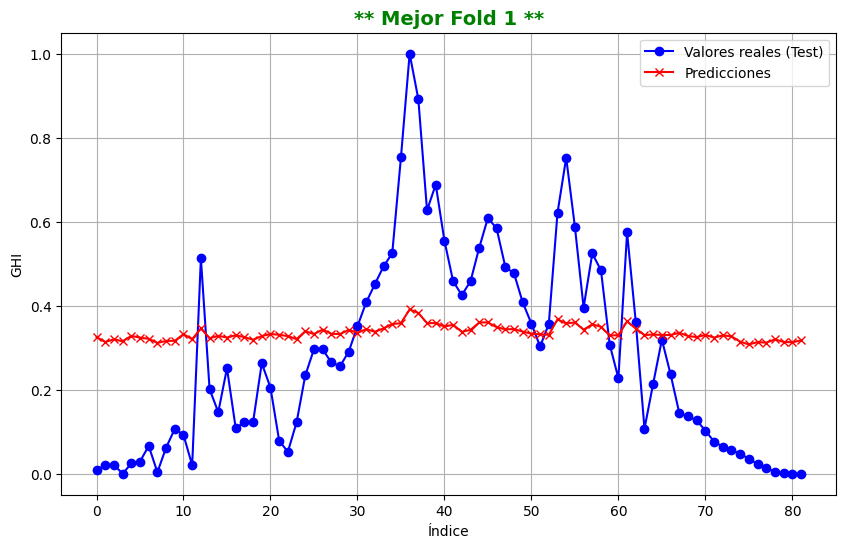

Fold 1 - Test MSE: 0.051742330195622764


=== Fold 2 ===
Forma de X_train_images: (164, 64, 64, 3)
Forma de X_train_numerical: (164, 3)
Forma de y_train: (164, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=64, MSE=0.07143278202048275
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=128, MSE=0.10338812052170832
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=64, MSE=0.08130980200212624
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=128, MSE=0.11951

Guardado el modelo del Fold 2 en 'best_model_fold_2.h5'


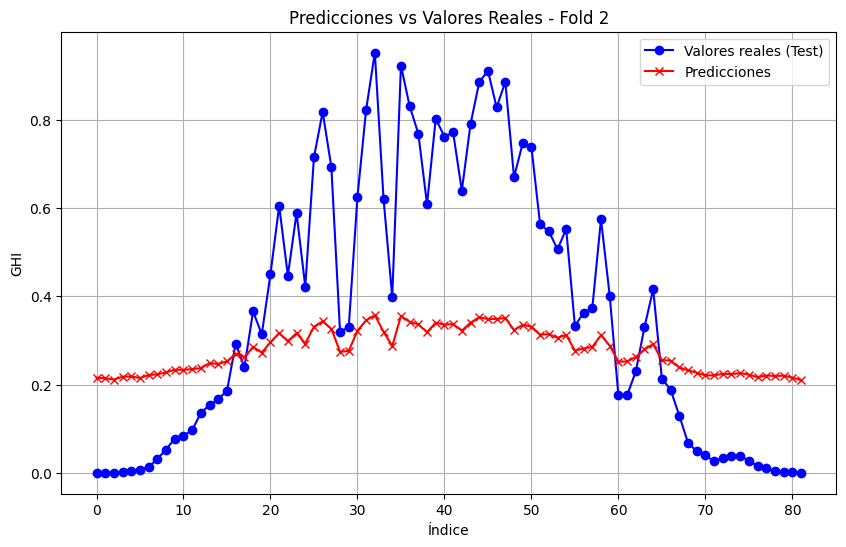

Fold 2 - Test MSE: 0.07553513984666291


=== Fold 3 ===
Forma de X_train_images: (246, 64, 64, 3)
Forma de X_train_numerical: (246, 3)
Forma de y_train: (246, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=64, MSE=0.07059881959470378
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=128, MSE=0.06698808605934839
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=64, MSE=0.13870984926086724
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=128, 

Guardado el modelo del Fold 3 en 'best_model_fold_3.h5'
Guardado el mejor modelo global en 'best_global_model.h5' con MSE: 0.00020841525370940102


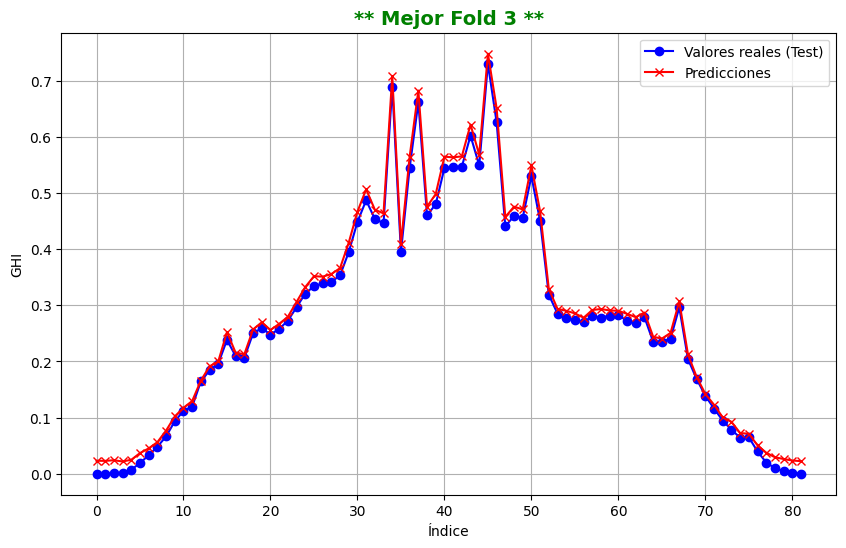

Fold 3 - Test MSE: 0.00020841525370940102


=== Fold 4 ===
Forma de X_train_images: (328, 64, 64, 3)
Forma de X_train_numerical: (328, 3)
Forma de y_train: (328, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=64, MSE=0.031848676279611694
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=128, MSE=0.09252873645093994
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=64, MSE=0.0330553020219154
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=128, MSE=0.014

Guardado el modelo del Fold 4 en 'best_model_fold_4.h5'
Guardado el mejor modelo global en 'best_global_model.h5' con MSE: 0.0001236638938730823


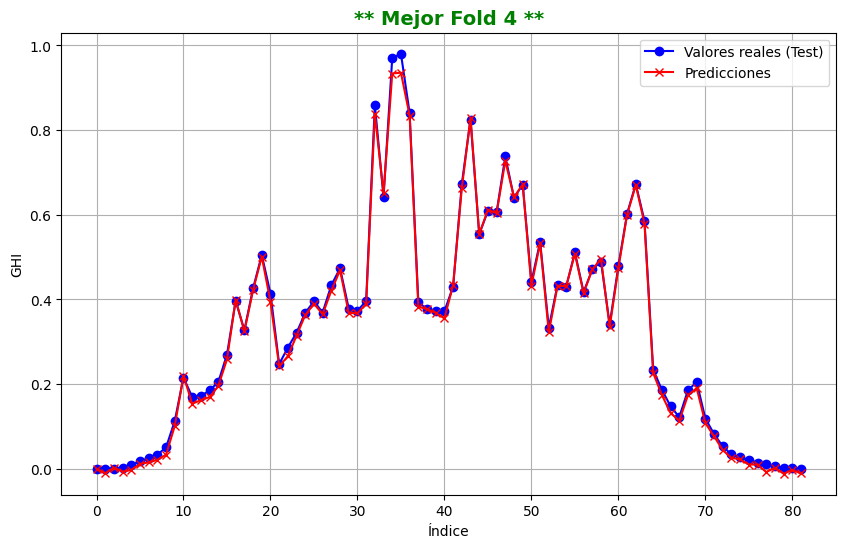

Fold 4 - Test MSE: 0.0001236638938730823


=== Fold 5 ===
Forma de X_train_images: (410, 64, 64, 3)
Forma de X_train_numerical: (410, 3)
Forma de y_train: (410, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=64, MSE=0.14052149430986674
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=128, Units_numeric=128, MSE=0.012084363957121515
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=64, MSE=0.02499674860096163
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Eval: Optimizer=adam, Activation=relu, Units_image=256, Units_numeric=128, MSE=0.003

Guardado el modelo del Fold 5 en 'best_model_fold_5.h5'


Guardado el mejor modelo global en 'best_global_model.h5' con MSE: 6.217766814386537e-05


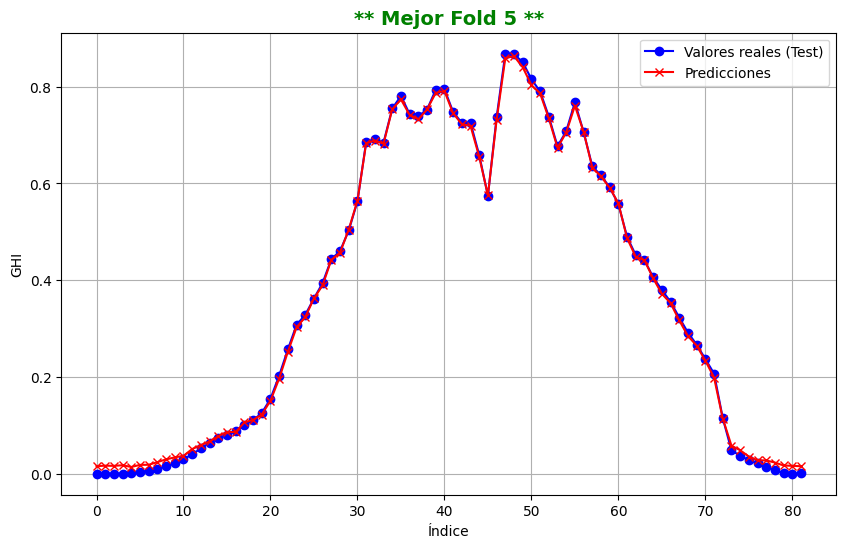

Fold 5 - Test MSE: 6.217766814386537e-05

Outer Scores: [0.051742330195622764, 0.07553513984666291, 0.00020841525370940102, 0.0001236638938730823, 6.217766814386537e-05]
Mejores hiperparámetros por fold: [{'fold': 1, 'optimizer': 'adam', 'activation': 'relu', 'num_units_image': 256, 'num_units_numeric': 64}, {'fold': 2, 'optimizer': 'rmsprop', 'activation': 'relu', 'num_units_image': 256, 'num_units_numeric': 64}, {'fold': 3, 'optimizer': 'adam', 'activation': 'relu', 'num_units_image': 256, 'num_units_numeric': 128}, {'fold': 4, 'optimizer': 'adam', 'activation': 'relu', 'num_units_image': 256, 'num_units_numeric': 128}, {'fold': 5, 'optimizer': 'adam', 'activation': 'relu', 'num_units_image': 256, 'num_units_numeric': 128}]


AttributeError: 'DataFrame' object has no attribute 'append'

In [23]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Optimizers
    'activation': ['relu', 'tanh'],  # Activation functions
    'num_units_image': [128, 256],  # Units in the image model
    'num_units_numeric': [64, 128]  # Units in the numeric model
}

outer_scores, best_params_per_fold = n_cross_val(tensor_images, valores_numericos, y, param_grid, outer_splits=5, inner_splits=3)
# busqueda exhaustiva---- todas las combinaciones posibles. 


In [ ]:
# ver en keras la parte de recibir imagenes y numerica.
# cv hacerla manual, explicito.
# correlacion: hacerlo busqueda, cambiando la y y saber cuanto me debo ir hacia atras.
# prueba del resto de dias.
